In [3]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the generalized Lotka-Volterra model
def lotka_volterra(t, *params):
    num_species = int((np.sqrt(1 + 4 * len(params)) - 1) / 2)
    a = np.array(params[:num_species])
    b = np.array(params[num_species:]).reshape((num_species, num_species))
    
    # Initial conditions (global variable for simplicity, adjust as needed)
    y0 = initial_conditions[:num_species]
    
    def model(y, t):
        dydt = np.zeros(num_species)
        for i in range(num_species):
            interaction_term = sum(b[i, j] * y[j] for j in range(num_species))
            dydt[i] = a[i] * y[i] + y[i] * interaction_term
        return dydt
    
    solution = odeint(model, y0, t)
    return solution.ravel()

In [4]:
# data
t_data = np.linspace(0, 10, 100)  # Time points of your data
# pop_data = np.random.rand(100, 3)  # Population data for each species at each time point, adjust the dimensions as needed

# Generate population data with controlled distributions
num_points = 100
pop_data = np.zeros((num_points, 3))  # Initialize the array
pop_data[:, 0] = 50 + np.random.rand(num_points) * 50
pop_data[:, 1] = 10 + np.random.rand(num_points) * 40
pop_data[:, 2] = 10 + np.random.rand(num_points) * 40  # Adjust as needed

# initial populations
initial_conditions = [3, 2, 1]  # Initial population sizes, adjust as needed

# Flatten the data for fitting
pop_data_flattened = pop_data.ravel()

# Initial guess for parameters
# For 3 species, we need 3 growth rates and 3*3 interaction coefficients = 12 parameters in total
initial_guess = [0.1, -0.1, 0.05] + [0]*9  # Adjust based on your data

# Fit model to data
params, covariance = curve_fit(lotka_volterra, t_data, pop_data_flattened, p0=initial_guess)

# Print fitted parameters
print("Fitted parameters:", params)

Fitted parameters: [42.58359889 16.61799259 20.02168167 -0.38428565  3.47805856 -3.72730424
  0.0980561  -0.17866475 -0.57439945  0.16724923 -0.45471237 -0.57954428]


In [5]:
# Optional: Plot fitted model against data
fitted_populations = lotka_volterra(t_data, *params).reshape(-1, 3)

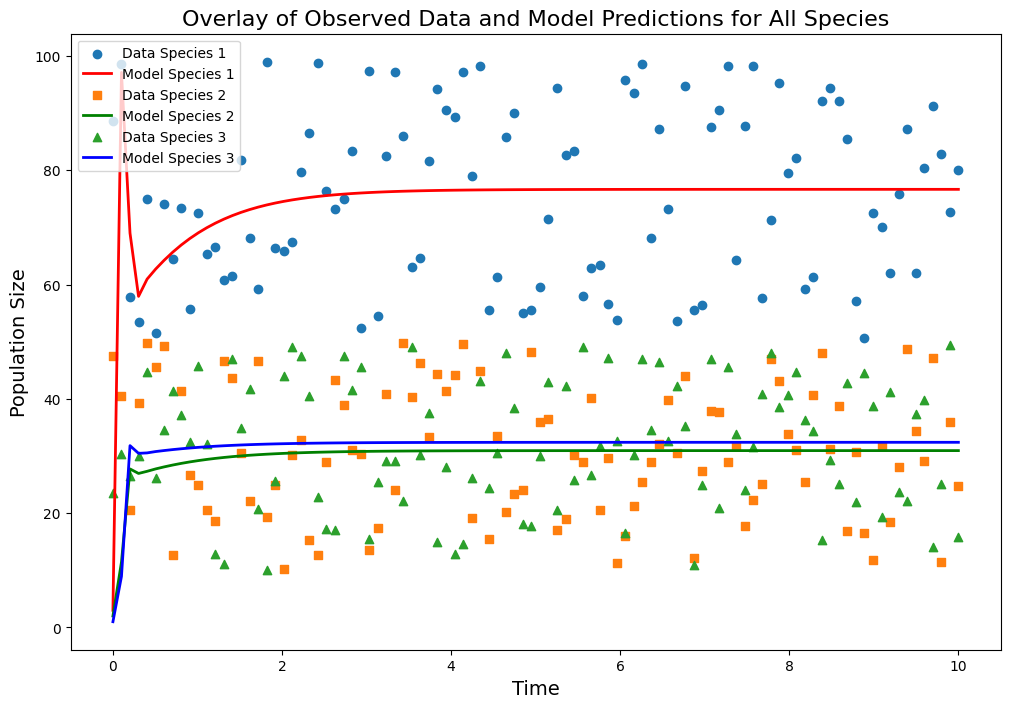

In [6]:
# Assuming `t_data`, `pop_data`, and `fitted_populations` are defined as before
# and `fitted_populations` is reshaped correctly according to the number of species

plt.figure(figsize=(12, 8))

# Define marker styles for observed data of different species
marker_styles = ['o', 's', '^', 'p', '*']  # Example: circle, square, triangle up, pentagon, star

# Define colors for model output of different species
colors = ['red', 'green', 'blue', 'purple', 'orange']

num_species = pop_data.shape[1]  # Determine the number of species from the data shape

for i in range(num_species):
    # Plot observed data for each species
    plt.scatter(t_data, pop_data[:, i], marker=marker_styles[i], label=f"Data Species {i+1}")
    
    # Plot model output for each species
    plt.plot(t_data, fitted_populations[:, i], color=colors[i], linestyle='-', linewidth=2, label=f"Model Species {i+1}")

plt.xlabel('Time', fontsize=14)
plt.ylabel('Population Size', fontsize=14)
plt.title('Overlay of Observed Data and Model Predictions for All Species', fontsize=16)
plt.legend()
plt.show()


In [7]:
import csv

time_list = []
population_size_list = []

with open('co-culture_data/Yeast_D hassenii.csv', mode='r') as file:
    # Create a CSV reader
    csv_reader = csv.reader(file)
    
    # Skip the header if there is one
    next(csv_reader, None)  # Remove this line if your CSV doesn't have a header
    
    # Iterate over the CSV rows
    for row in csv_reader:
        time_list.append(row[0])
        population_size_list.append(row[1])
        # print(row)  # Each 'row' is a list


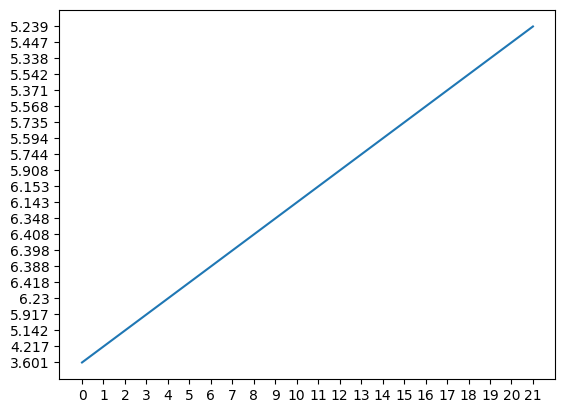

In [8]:
plt.plot(time_list, population_size_list)

## differential evolution

In [39]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import warnings
from scipy.integrate import solve_ivp


def lotka_volterra_model(t, params, num_species, initial_populations):
    """
    Generalized Lotka-Volterra model for use with differential evolution.
    
    Parameters:
    t (array): Time points.
    params (array): Parameters of the model (growth rates and interaction coefficients).
    num_species (int): Number of species.
    initial_populations (array): Initial populations of each species.
    
    Returns:
    solution (array): Flattened array of population sizes for all species over time.
    """
    # Extract parameters
    growth_rates = params[:num_species]
    interaction_coeffs = np.reshape(params[num_species:], (num_species, num_species))
    
    # Define the differential equations
    def equations(populations, t):
        derivatives = np.zeros(num_species)
        for i in range(num_species):
            growth_effect = growth_rates[i] * populations[i]
            interaction_effect = sum(interaction_coeffs[i, j] * populations[i] * populations[j] for j in range(num_species))
            derivatives[i] = growth_effect + interaction_effect
        return derivatives

    # # Suppress warnings for the duration of the odeint call
    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore")
    #     solution = odeint(equations, initial_populations, t)
        
    # # Solve the model
    # solution = odeint(equations, initial_populations, t)

    t_span = (0.0, t)
    solution = solve_ivp(fun=equations, t_span=t_span, y0=initial_populations, method='LSODA')

    return solution.ravel()


In [41]:
# help(solve_ivp)

### generate synthetic data

In [42]:
NUM_SPECIES = 2
t_data = np.linspace(0, 10, 100)
true_params = [0.5, -0.3, -0.01, 0.01, -0.02, 0.02]  # Example true parameters
initial_populations = [6, 6]

# Generate synthetic data
synthetic_data = lotka_volterra_model(t_data, true_params, NUM_SPECIES, initial_populations)
synthetic_data = synthetic_data.reshape(-1, NUM_SPECIES) + np.random.normal(scale=0.5, size=(len(t_data), NUM_SPECIES))


TypeError: only length-1 arrays can be converted to Python scalars

### fit the data

In [18]:
def objective_function(params, t_data, num_species, initial_populations, observed_data):
    """
    Objective function to minimize, computes the sum of squared errors.
    """
    model_predictions = lotka_volterra_model(t_data, params, num_species, initial_populations)
    model_predictions = model_predictions.reshape(-1, num_species)
    return np.sum((observed_data - model_predictions) ** 2)

# Initial guess (not needed for differential evolution but defining structure)
guess = [1 for _ in range(NUM_SPECIES)] + [0] * (NUM_SPECIES * NUM_SPECIES)

# Bounds for parameters: growth rates might vary between -1 and 1, interaction coefficients between -0.1 and 0.1
bounds = [(-1, 1)] * NUM_SPECIES + [(-0.1, 0.1)] * (NUM_SPECIES * NUM_SPECIES)

# Perform the differential evolution optimization
result = differential_evolution(
    objective_function, 
    bounds, 
    args=(t_data, NUM_SPECIES, initial_populations, synthetic_data),
    strategy='best1bin', 
    maxiter=1000, 
    popsize=15,
    tol=0.01, 
    mutation=(0.5, 1), 
    recombination=0.7
)

print("Fitted parameters:", result.x)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5964094748657D+01   r2 =  0.4165762537355D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5964094748657D+01   r2 =  0.4165762537355D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5964094748657D+01   r2 =  0.3449178851590D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5964094748657D+01   r2 =  0.3449178851590D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/vy/vr0_ytms6m95qrnk7xnh0bth0000gq/T/ipykernel_68505/3423853624.py:7: RuntimeWarning: overflow encountered in square
  return np.sum((observed_data - model_predictions) ** 2)
/var/folders/vy/vr0_ytms6m95qrnk7xnh0bth0000gq/T/ipykernel_68505/3423853624.py:7: RuntimeWarning: overflow encountered in square
  return np.sum((observed_data - model_predictions) ** 2)
/var/folders/vy/vr0_ytms6m95qrnk7xnh0bth0000gq/T/ipykernel_68505/3423853624.py:7: RuntimeWarning: overflow encountered in square
  return np.sum((observed_data - model_predictions) ** 2)
/var/folders/vy/vr0_ytms6m95qrnk7xnh0bth0000gq/T/ipykernel_68505/3423853624.py:7: RuntimeWarning: overflow encountered in square
  return np.sum((observed_data - model_predictions) ** 2)
/var/folders/vy/vr0_ytms6m95qrnk7xnh0bth0000gq/T/ipykernel_68505/3423853624.py:7: RuntimeWarning: overflow encountered in square
  return np.sum((observed_data - model_predictions) ** 2)
/var/folders/vy/vr0_ytms6m95qrnk7xnh0bth0000gq/T/ipykernel_68505/

and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5457676159328D+01   r2 =  0.3194879810531D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5457676159328D+01   r2 =  0.2556729671988D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5457676159328D+01   r2 =  0.2556729671988D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5457676159328D+01   r2 =  0.2116927653630D-15
 lsoda--  above warning has been issued i1 times.    
       it will not

/var/folders/vy/vr0_ytms6m95qrnk7xnh0bth0000gq/T/ipykernel_68505/3423853624.py:7: RuntimeWarning: overflow encountered in square
  return np.sum((observed_data - model_predictions) ** 2)
/var/folders/vy/vr0_ytms6m95qrnk7xnh0bth0000gq/T/ipykernel_68505/3423853624.py:7: RuntimeWarning: overflow encountered in square
  return np.sum((observed_data - model_predictions) ** 2)


  r1 =  0.6883502627547D+01   r2 =  0.3400204791339D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6883502627547D+01   r2 =  0.2815310367135D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6883502627547D+01   r2 =  0.2815310367135D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6883502627547D+01   r2 =  0.2815310367135D-15
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in

In [12]:
# Model predictions using fitted parameters
fitted_model_predictions = lotka_volterra_model(t_data, result.x, NUM_SPECIES, initial_populations)
fitted_model_predictions = fitted_model_predictions.reshape(-1, NUM_SPECIES)

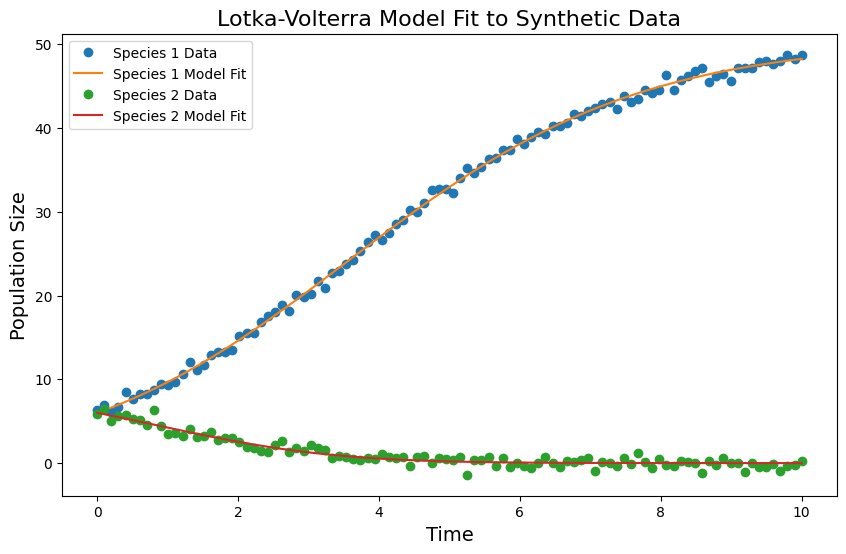

In [13]:
# Assuming `t_data`, `synthetic_data`, and `fitted_model_predictions` are defined as previously mentioned
plt.figure(figsize=(10, 6))
for i in range(NUM_SPECIES):
    # Plot synthetic data
    plt.plot(t_data, synthetic_data[:, i], 'o', label=f'Species {i+1} Data')
    # Plot model predictions
    plt.plot(t_data, fitted_model_predictions[:, i], '-', label=f'Species {i+1} Model Fit')

plt.xlabel('Time', fontsize=14)
plt.ylabel('Population Size', fontsize=14)
plt.title('Lotka-Volterra Model Fit to Synthetic Data', fontsize=16)
plt.legend()
plt.show()

